In [1]:
# Импорт библиотек
from google.colab import drive
import numpy as np
import pandas as pd
import os
import zipfile
import shutil
from tqdm import tqdm
import torch
import torchvision
import matplotlib.pyplot as plt
import time
import copy
from torchvision import transforms, models

In [2]:
# Монтируем Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Путь к архиву с данными и вывод содержимого диска
print(os.listdir("/content/drive/MyDrive/"))
root_to_zip = '/content/drive/MyDrive/plates.zip'

['Untitled spreadsheet (3).gsheet', 'Untitled spreadsheet (2).gsheet', '34.c', '20.c', '25.c', '27.c', '35.c', '28.c', '29.c', '31.c', '32.c', 'Все задачи (кроме 1, 2, 3 и 18) Гореев Марат (!!! WARNING !!! ГОВНОКОД !!! Использовать на свой страх и риск)', 'Goreev.mb', 'Гореев (11)', 'Гореев (10)', 'Гореев (9)', 'Гореев (8)', 'Гореев (7)', 'Гореев (6)', 'Goreev (1).fbx', 'Goreev.fbx', 'Гореев (5)', 'Гореев (4)', 'Курсовой проект', 'Записи лекций | 4 семестр', 'GraphicalApp', 'Гореев Марат (1)', 'graphical', 'Б9120-02.03.01сцт.gsheet', 'Гореев (3)', 'Гореев (2)', 'Marat Goreev 1dz.fbx', 'Marat Goreev.fbx', 'Гореев Марат', 'Гореев (1)', 'Goreev Marat.fbx', 'Гореев', 'Графика', 'Goreev house.fbx', 'dsp', 'Сарьян.dt', 'Новая таблица.gsheet', 'Untitled spreadsheet (1).gsheet', 'Untitled spreadsheet.gsheet', 'backup', 'Copy of [Рейтинговая таблица].gsheet', 'Copy of [Жизнепоиск].gsheet', '[Жизнепоиск].gsheet', 'To-do list.gsheet', 'Annual Calendar.gsheet', 'Schedule.gsheet', 'Weekly time 

In [4]:
# Распаковка архива
with zipfile.ZipFile(root_to_zip, 'r') as zip_obj:
    zip_obj.extractall('/content/')

In [5]:
# Вывод содержимого каталога
print(os.listdir("/content"))
print(os.listdir("/content/plates"))

['.config', 'drive', '__MACOSX', 'plates', 'sample_data']
['test', 'train', '.DS_Store']


In [6]:
# Определение корневого каталога с данными
data_root = '/content/plates/'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [7]:
# Разделение данных на обучающий и валидационный наборы
train_dir = '/content/train'
val_dir = '/content/val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

!ls /content/train

100%|██████████| 21/21 [00:00<00:00, 5452.21it/s]

cleaned  dirty


In [8]:
# Трансформации для обучающего и валидационного наборов данных
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(hue=0.2),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.CenterCrop(200),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Создание датасетов для обучения и валидации
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

len(train_dataloader), len(train_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(2, 32)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


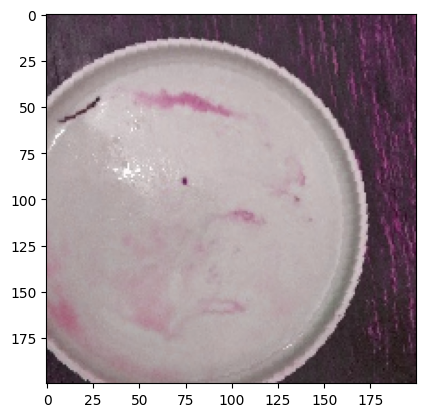

In [9]:
# Визуализация изображений из обучающего набора данных
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

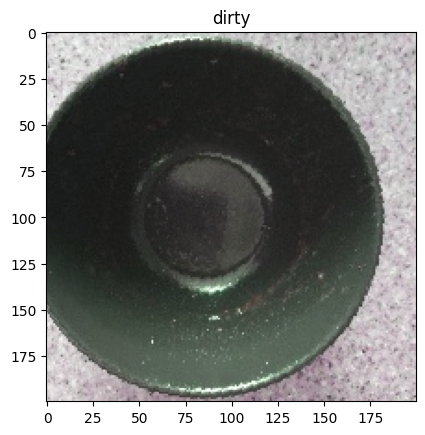

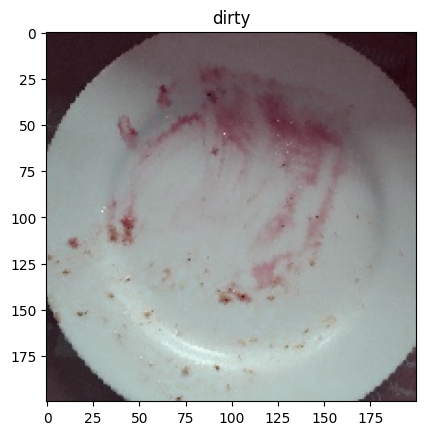

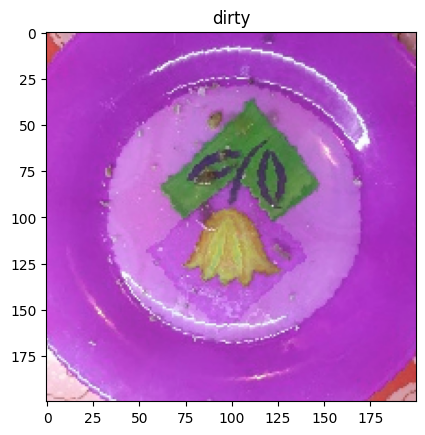

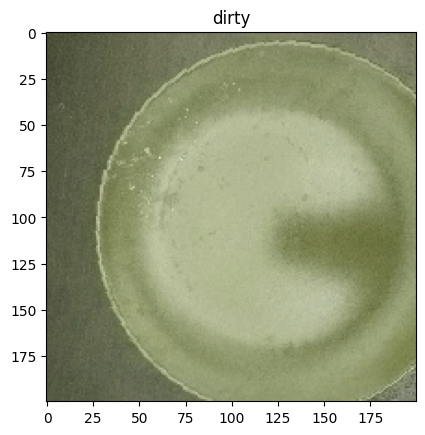

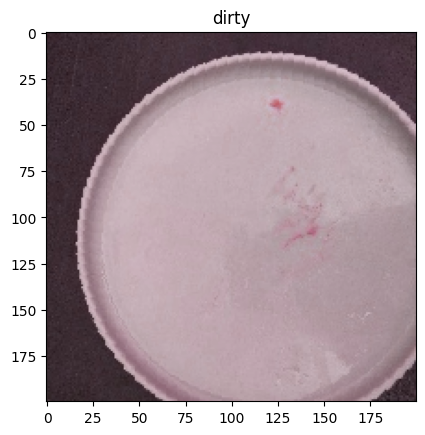

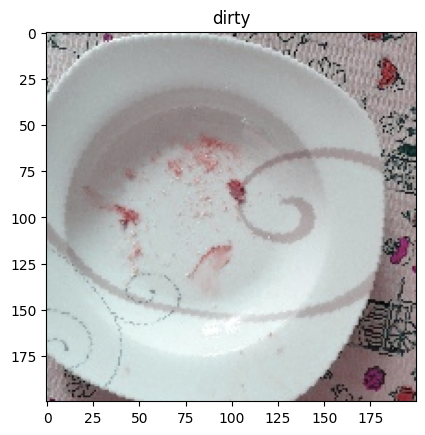

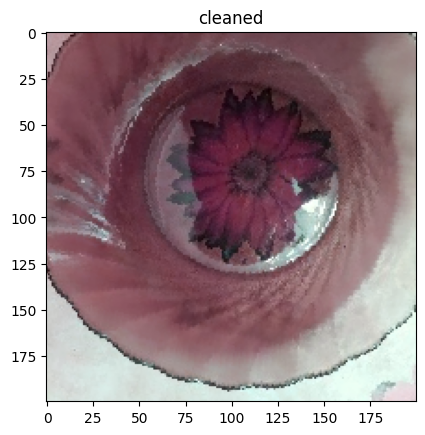

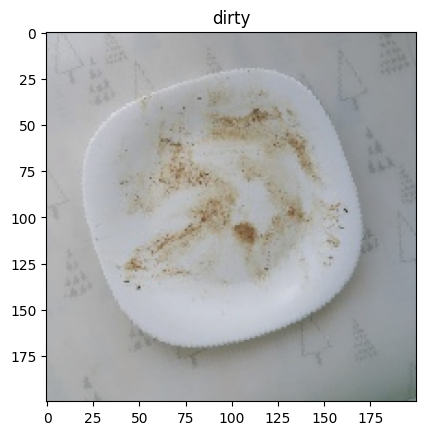

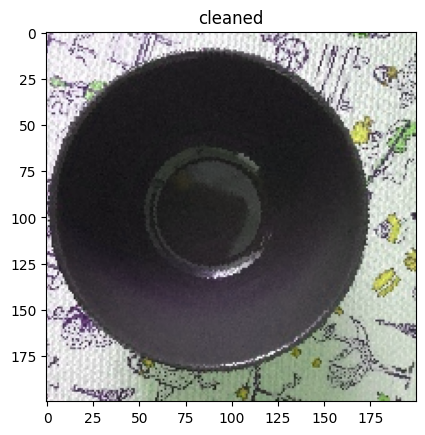

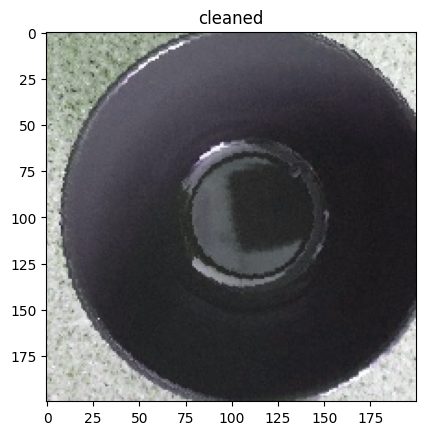

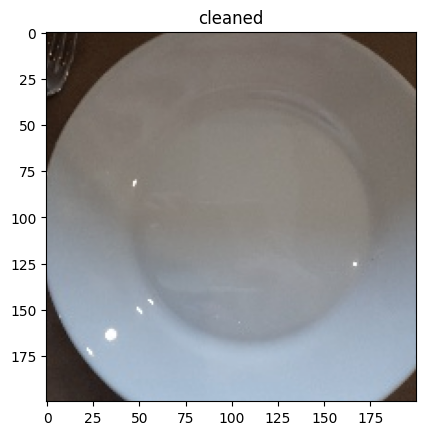

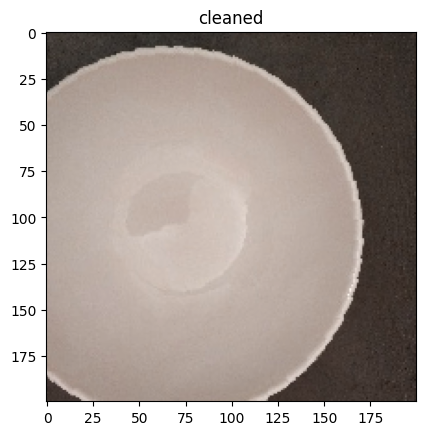

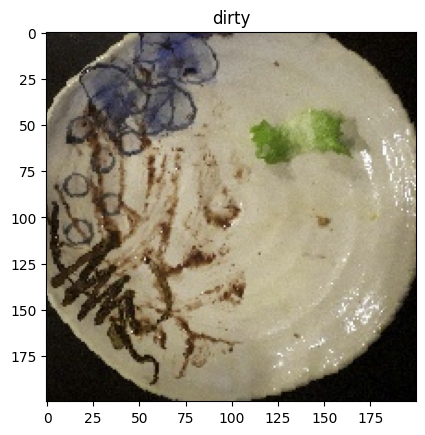

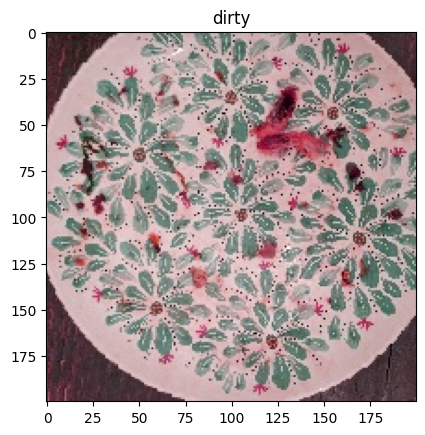

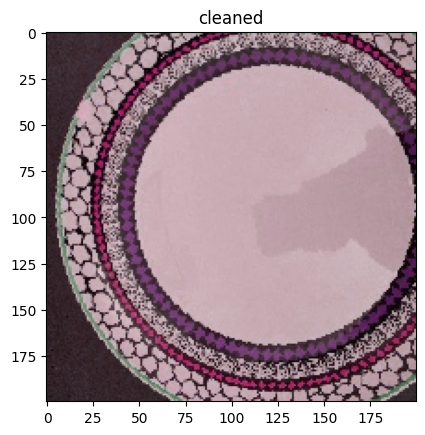

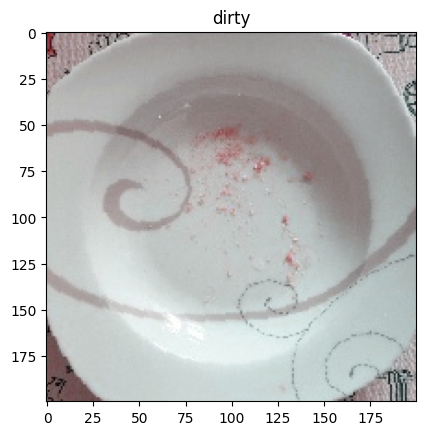

In [10]:
# Функция для отображения изображений
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [11]:
# Функция для обучения модели
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()
            else:
                dataloader = val_dataloader
                model.eval()

            running_loss = 0.
            running_acc = 0.

            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [12]:
# Инициализация модели ResNet152
model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 87.4MB/s]


In [13]:
# Обучение модели
train_model(model, loss, optimizer, scheduler, num_epochs=14)

Epoch 0/13:


100%|██████████| 2/2 [00:11<00:00,  5.72s/it]

train Loss: 1.0594 Acc: 0.3750



100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

val Loss: 0.8833 Acc: 0.5000
Epoch 1/13:



100%|██████████| 2/2 [00:11<00:00,  5.99s/it]

train Loss: 0.7324 Acc: 0.4688



100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

val Loss: 0.7080 Acc: 0.5000
Epoch 2/13:



100%|██████████| 2/2 [00:11<00:00,  5.61s/it]

train Loss: 0.7445 Acc: 0.5000



100%|██████████| 1/1 [00:02<00:00,  2.93s/it]

val Loss: 0.7202 Acc: 0.5000
Epoch 3/13:



100%|██████████| 2/2 [00:12<00:00,  6.06s/it]

train Loss: 0.7194 Acc: 0.5312



100%|██████████| 1/1 [00:03<00:00,  3.45s/it]

val Loss: 0.6771 Acc: 0.5000
Epoch 4/13:



100%|██████████| 2/2 [00:11<00:00,  5.54s/it]

train Loss: 0.5815 Acc: 0.7500



100%|██████████| 1/1 [00:03<00:00,  3.26s/it]

val Loss: 0.7390 Acc: 0.5000
Epoch 5/13:



100%|██████████| 2/2 [00:10<00:00,  5.47s/it]

train Loss: 0.5897 Acc: 0.6562



100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

val Loss: 0.7419 Acc: 0.5000
Epoch 6/13:



100%|██████████| 2/2 [00:11<00:00,  5.59s/it]

train Loss: 0.5813 Acc: 0.6562



100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

val Loss: 0.6695 Acc: 0.6250
Epoch 7/13:



100%|██████████| 2/2 [00:11<00:00,  5.53s/it]

train Loss: 0.4954 Acc: 0.8438



100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

val Loss: 0.6057 Acc: 0.5000
Epoch 8/13:



100%|██████████| 2/2 [00:11<00:00,  5.66s/it]

train Loss: 0.5100 Acc: 0.8125



100%|██████████| 1/1 [00:03<00:00,  3.15s/it]

val Loss: 0.5936 Acc: 0.7500
Epoch 9/13:



100%|██████████| 2/2 [00:11<00:00,  5.59s/it]

train Loss: 0.4689 Acc: 0.7812



100%|██████████| 1/1 [00:03<00:00,  3.41s/it]

val Loss: 0.5971 Acc: 0.6250
Epoch 10/13:



100%|██████████| 2/2 [00:11<00:00,  5.66s/it]

train Loss: 0.4402 Acc: 0.9062



100%|██████████| 1/1 [00:02<00:00,  2.97s/it]

val Loss: 0.6142 Acc: 0.6250
Epoch 11/13:



100%|██████████| 2/2 [00:11<00:00,  5.59s/it]

train Loss: 0.4000 Acc: 0.9375



100%|██████████| 1/1 [00:02<00:00,  2.95s/it]

val Loss: 0.6304 Acc: 0.6250
Epoch 12/13:



100%|██████████| 2/2 [00:11<00:00,  5.60s/it]

train Loss: 0.3999 Acc: 0.9062



100%|██████████| 1/1 [00:03<00:00,  3.11s/it]

val Loss: 0.6327 Acc: 0.6250
Epoch 13/13:



100%|██████████| 2/2 [00:11<00:00,  5.76s/it]

train Loss: 0.3851 Acc: 0.9062



100%|██████████| 1/1 [00:03<00:00,  3.43s/it]

val Loss: 0.5827 Acc: 0.5000


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# Подготовка тестового датасета и предсказания модели
test_dir = '/content/plates/test'

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [15]:
# Получение предсказаний модели на тестовом датасете
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

100%|██████████| 47/47 [04:14<00:00,  5.42s/it]


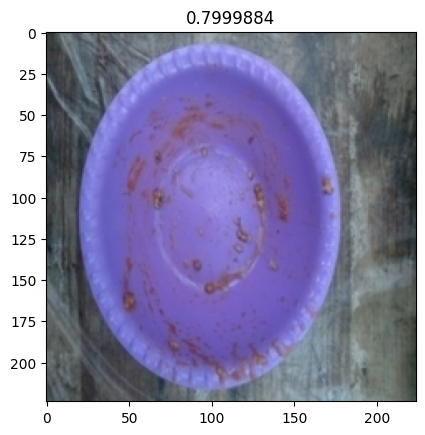

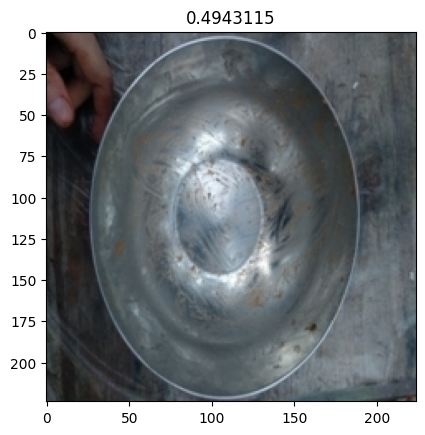

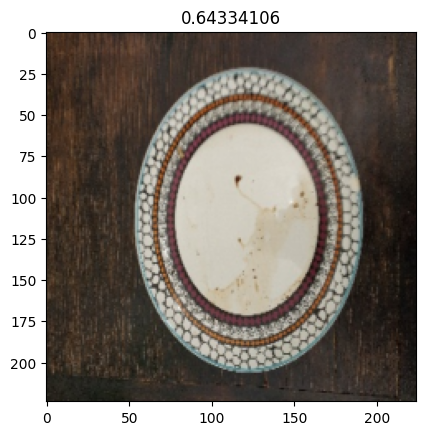

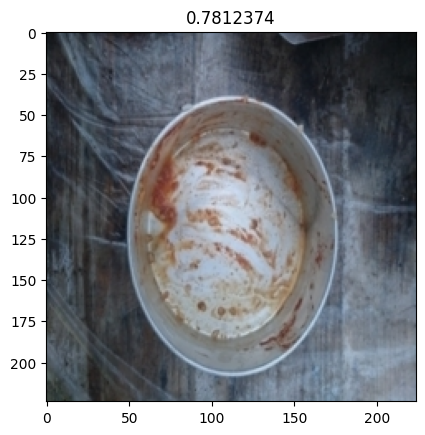

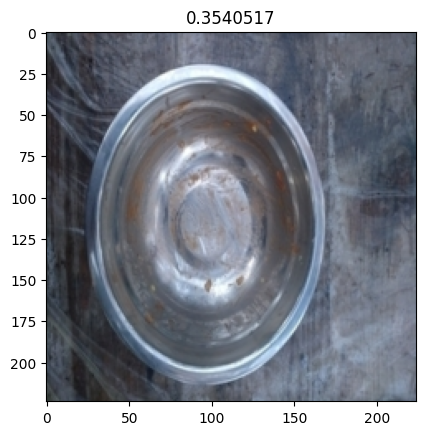

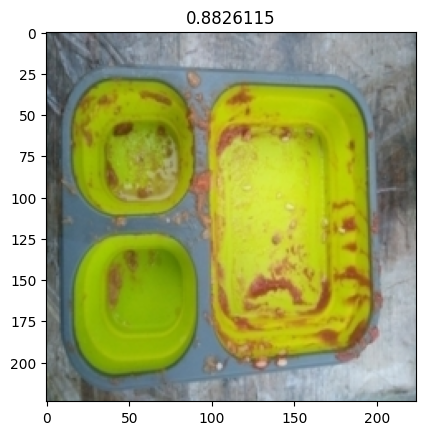

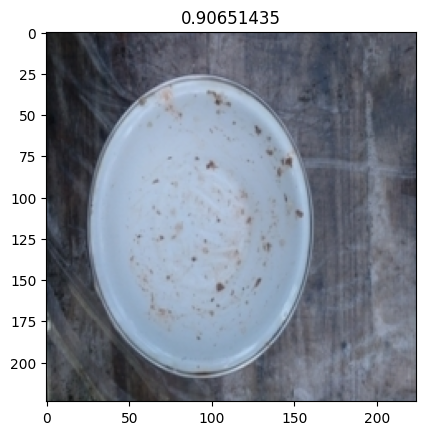

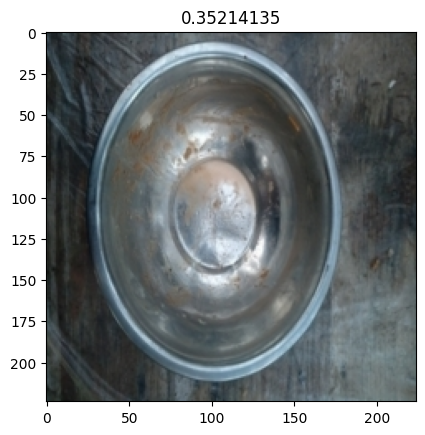

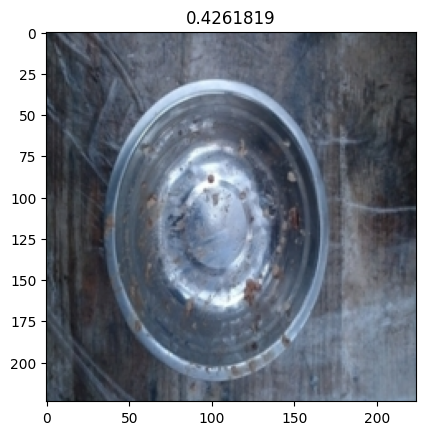

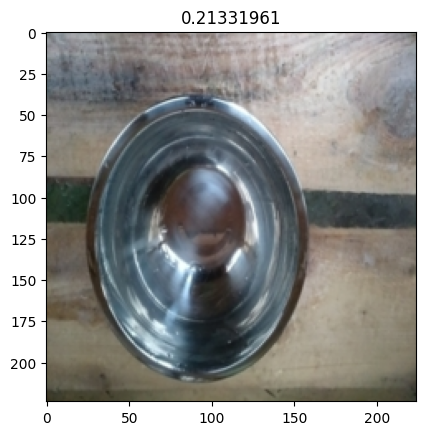

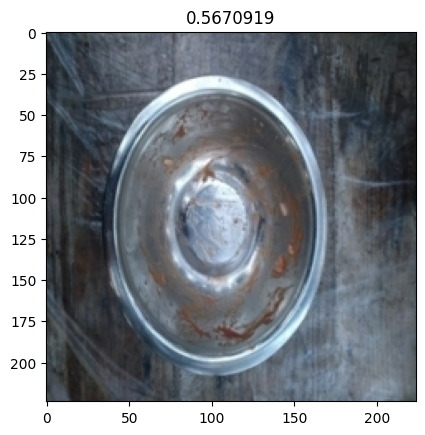

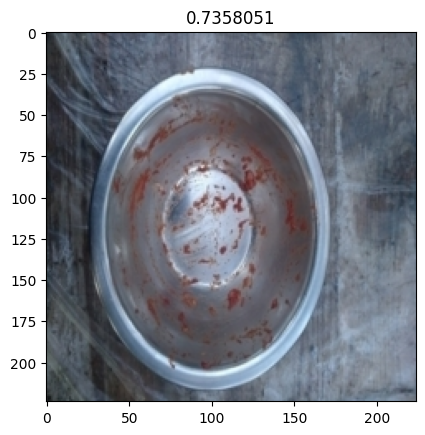

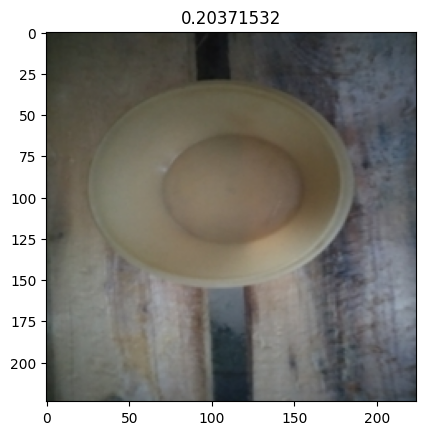

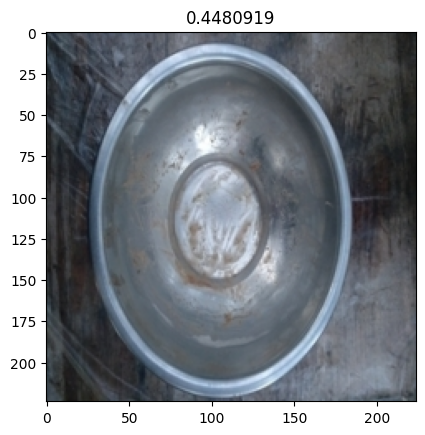

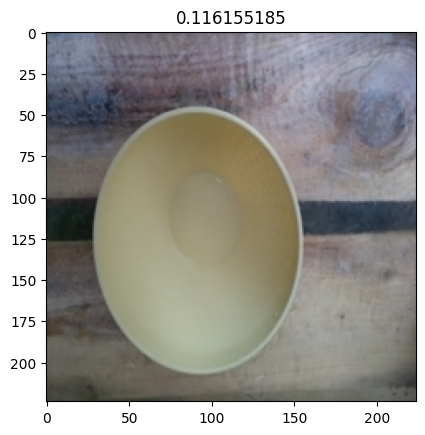

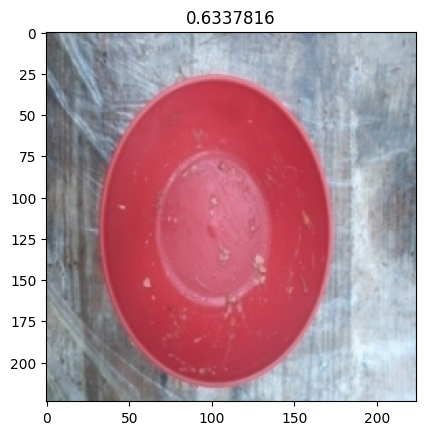

In [16]:
# Визуализация предсказаний на изображениях из тестового датасета
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [17]:
# Создание и сохранение файла с предсказаниями
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.54 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/content/plates/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)

submission_df.to_csv('/content/submission.csv')